In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("../../thesis-style.mpl")
import thesis

In [2]:
import numpy as np

In [3]:
import elk.catalogue

/home/daniel/.virtualenvs/IGRlaptop21/thesis/lib/python2.7/site-packages/h5py-2.7.0-py2.7-linux-x86_64.egg/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
catalogue = elk.catalogue.NRCatalogue(origin="GeorgiaTech")

In [37]:
data = catalogue.waveforms[0].timeseries(total_mass=60, sample_rate = 1024)

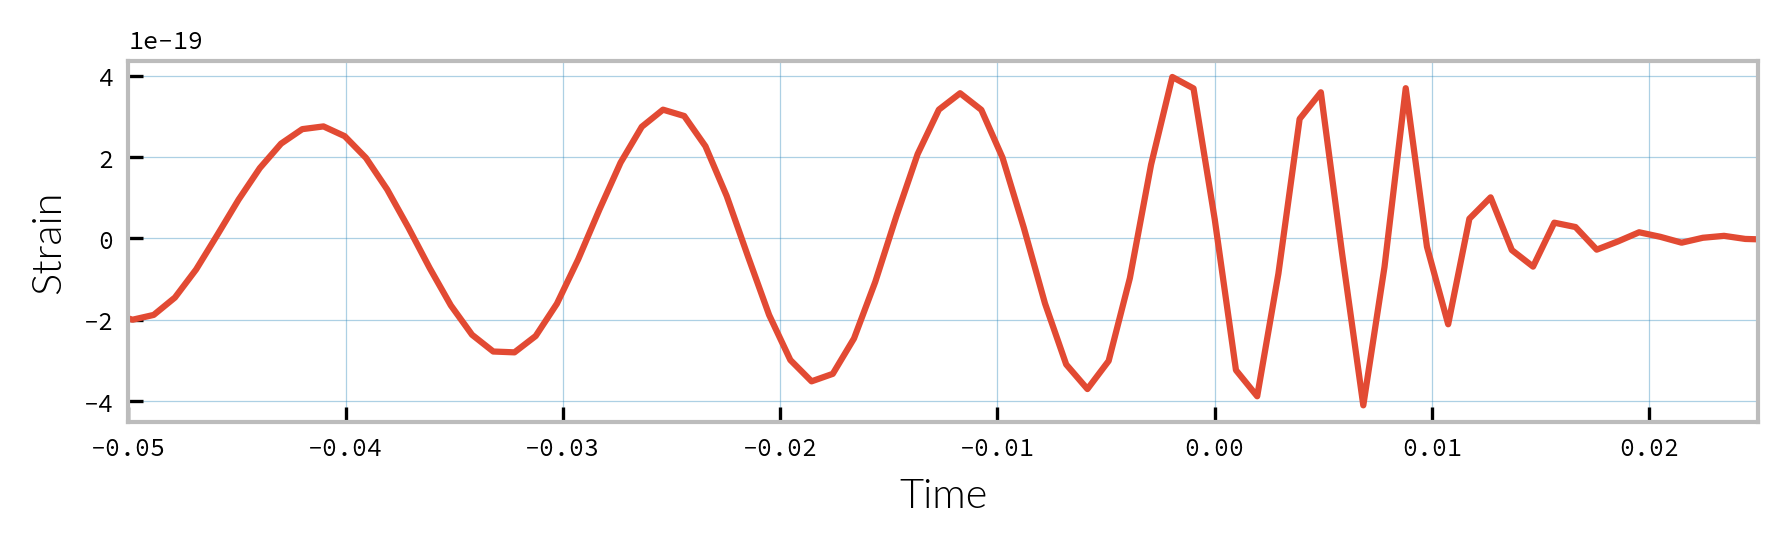

In [38]:
f, ax = plt.subplots(1,1, dpi=300);
ax.plot(data[0].times, data[0].data);
ax.set_ylabel("Strain");
ax.set_xlabel("Time");
ax.set_xlim([-0.050, 0.025])
thesis.thesisify(f, height=0.5);

In [39]:
Y = data[0].data *1e19
X = np.atleast_2d(data[0].times)

In [40]:
import pymc3 as pm

In [62]:
#X = x[(0),:5000][::,None]#.T
#Y = y[:5000]

with pm.Model() as model:
    
    amp_t = pm.Uniform("amplitude_time", 1, 15)
    #amp_q = pm.Uniform("amplitude_q", 1, 15)
    ls_t =  pm.Uniform("time", 0, .01) #pm.Gamma("metric_time", alpha=3, beta=0.5)
    #ls_q = pm.Uniform("metric_q", 0,1)#pm.Gamma("metric_q", alpha=3, beta=0.5)
    #ls_L = pm.Uniform("metric_L", 0,1, shape=3)
    # Specify the covariance function.
    
    cov_func = pm.gp.cov.ExpQuad(1, ls=ls_t) #*pm.gp.cov.ExpQuad(1, active_dims=[2], ls=ls_q) #* pm.gp.cov.ExpQuad(3, active_dims=(8,9,10), ls=ls_L)

    
    gp = pm.gp.Marginal(cov_func=cov_func)
    
    s = pm.Normal("sigma", .00125, 0.1)
    y_ = gp.marginal_likelihood("y", X=X.T, y=Y, noise=0.0001, is_observed=True)

In [63]:
with model:
    mp = pm.find_MAP()

logp = -172.52, ||grad|| = 164.23: 100%|██████████| 28/28 [00:00<00:00, 36.41it/s]        


/home/daniel/.virtualenvs/IGRlaptop21/thesis/lib/python2.7/site-packages/matplotlib/backends/backend_pdf.py:1120: UserWarning: 'SourceCodePro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
  warnings.warn(msg % os.path.basename(filename))


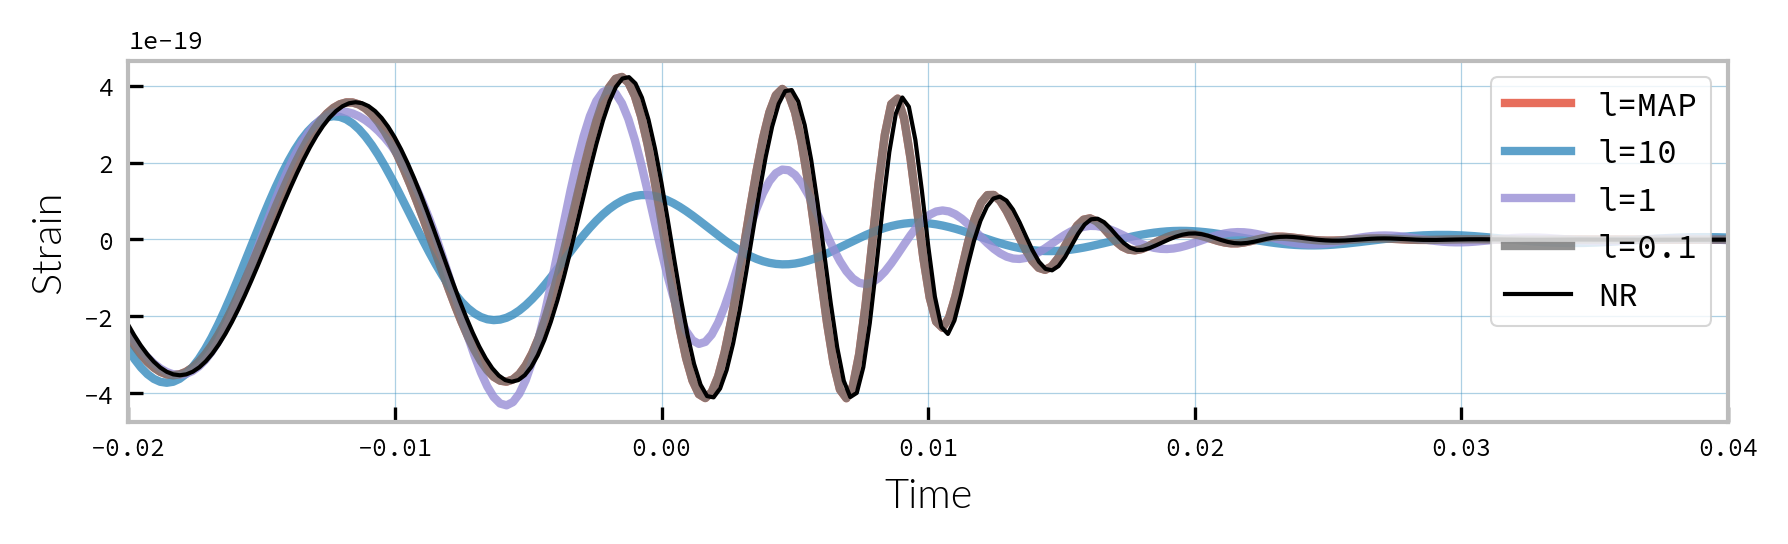

In [65]:
f, ax = plt.subplots(1,1, dpi=300);

ax.set_ylabel("Strain");
ax.set_xlabel("Time");

t_new = np.linspace(-0.02,0.1, 500)[::,None]

mu, var = gp.predict(t_new, point=mp, diag=True)
sd = np.sqrt(var)
ax.plot(t_new, mu/1e19, label="l=MAP".format(mp['time']), lw=2, alpha=0.8)

for l in [10, 1, 0.1]:

    mp['time'] = np.array(l)
    mp['time_interval__'] = np.array(np.log(mp['time']))
    mu, var = gp.predict(t_new, point=mp, diag=True)
    sd = np.sqrt(var)
    ax.plot(t_new, mu/1e19, label="l={}".format(l), lw=2, alpha=0.8)

    

ax.set_xlim([-0.02, 0.04])
    
data = catalogue.waveforms[0].timeseries(total_mass=60, sample_rate = 4096)
ax.plot(data[0].times, data[0].data, label="NR", color ='k', lw=1);
ax.legend(prop=thesis.ssp_legend, loc="upper right")

thesis.thesisify(f, height=0.5);

f.savefig("../../figures/gp/single-waveform.pdf")


In [55]:
#X = x[(0),:5000][::,None]#.T
#Y = y[:5000]

with pm.Model() as model:
    
    amp_t = pm.Uniform("amplitude_time", 1, 15)
    #amp_q = pm.Uniform("amplitude_q", 1, 15)
    ls_t =  pm.Uniform("time", 0, .01) #pm.Gamma("metric_time", alpha=3, beta=0.5)
    #ls_q = pm.Uniform("metric_q", 0,1)#pm.Gamma("metric_q", alpha=3, beta=0.5)
    #ls_L = pm.Uniform("metric_L", 0,1, shape=3)
    # Specify the covariance function.
    
    cov_func = pm.gp.cov.RatQuad(1, alpha=10,  ls=ls_t) #*pm.gp.cov.ExpQuad(1, active_dims=[2], ls=ls_q) #* pm.gp.cov.ExpQuad(3, active_dims=(8,9,10), ls=ls_L)

    
    gp = pm.gp.Marginal(cov_func=cov_func)
    
    s = pm.Normal("sigma", .00125, 0.1)
    y_ = gp.marginal_likelihood("y", X=X.T, y=Y, noise=0.0001, is_observed=True)

In [56]:
with model:
    mp = pm.find_MAP()

logp = -178.72, ||grad|| = 24.49: 100%|██████████| 26/26 [00:00<00:00, 58.26it/s]          


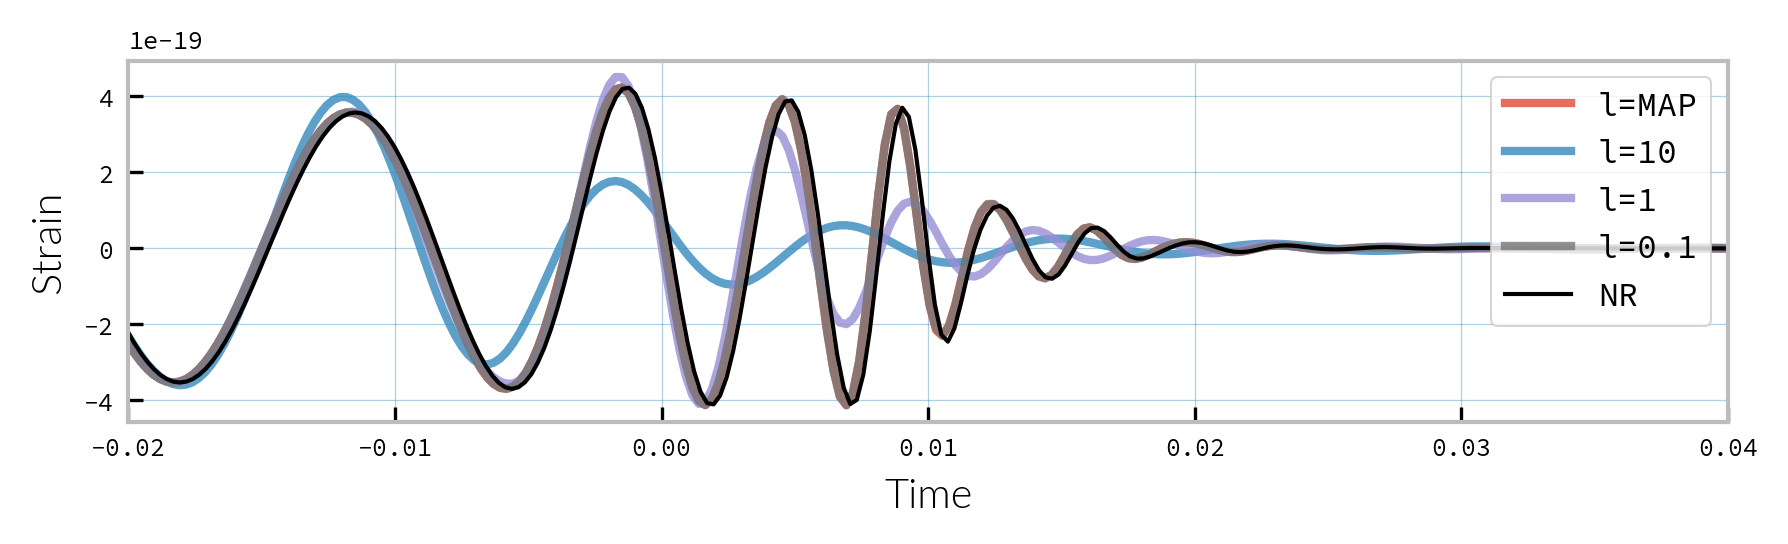

In [57]:
f, ax = plt.subplots(1,1, dpi=300);

ax.set_ylabel("Strain");
ax.set_xlabel("Time");

t_new = np.linspace(-0.02,0.1, 500)[::,None]

mu, var = gp.predict(t_new, point=mp, diag=True)
sd = np.sqrt(var)
ax.plot(t_new, mu/1e19, label="l=MAP".format(mp['time']), lw=2, alpha=0.8)

for l in [10, 1, 0.1]:

    mp['time'] = np.array(l)
    mp['time_interval__'] = np.array(np.log(mp['time']))
    mu, var = gp.predict(t_new, point=mp, diag=True)
    sd = np.sqrt(var)
    ax.plot(t_new, mu/1e19, label="l={}".format(l), lw=2, alpha=0.8)

    

ax.set_xlim([-0.02, 0.04])
    
data = catalogue.waveforms[0].timeseries(total_mass=60, sample_rate = 4096)
ax.plot(data[0].times, data[0].data, label="NR", color ='k', lw=1);
ax.legend(prop=thesis.ssp_legend, loc="upper right")

thesis.thesisify(f, height=0.5);



In [58]:
#X = x[(0),:5000][::,None]#.T
#Y = y[:5000]

with pm.Model() as model:
    
    amp_t = pm.Uniform("amplitude_time", 1, 15)
    #amp_q = pm.Uniform("amplitude_q", 1, 15)
    ls_t =  pm.Uniform("time", 0, .01) #pm.Gamma("metric_time", alpha=3, beta=0.5)
    #ls_q = pm.Uniform("metric_q", 0,1)#pm.Gamma("metric_q", alpha=3, beta=0.5)
    #ls_L = pm.Uniform("metric_L", 0,1, shape=3)
    # Specify the covariance function.
    
    cov_func = pm.gp.cov.Exponential(1, ls_t) #*pm.gp.cov.ExpQuad(1, active_dims=[2], ls=ls_q) #* pm.gp.cov.ExpQuad(3, active_dims=(8,9,10), ls=ls_L)

    
    gp = pm.gp.Marginal(cov_func=cov_func)
    
    s = pm.Normal("sigma", .00125, 0.1)
    y_ = gp.marginal_likelihood("y", X=X.T, y=Y, noise=0.0001, is_observed=True)

In [59]:
with model:
    mp = pm.find_MAP()

logp = -518.24, ||grad|| = 209.76: 100%|██████████| 9/9 [00:00<00:00, 46.67it/s]   


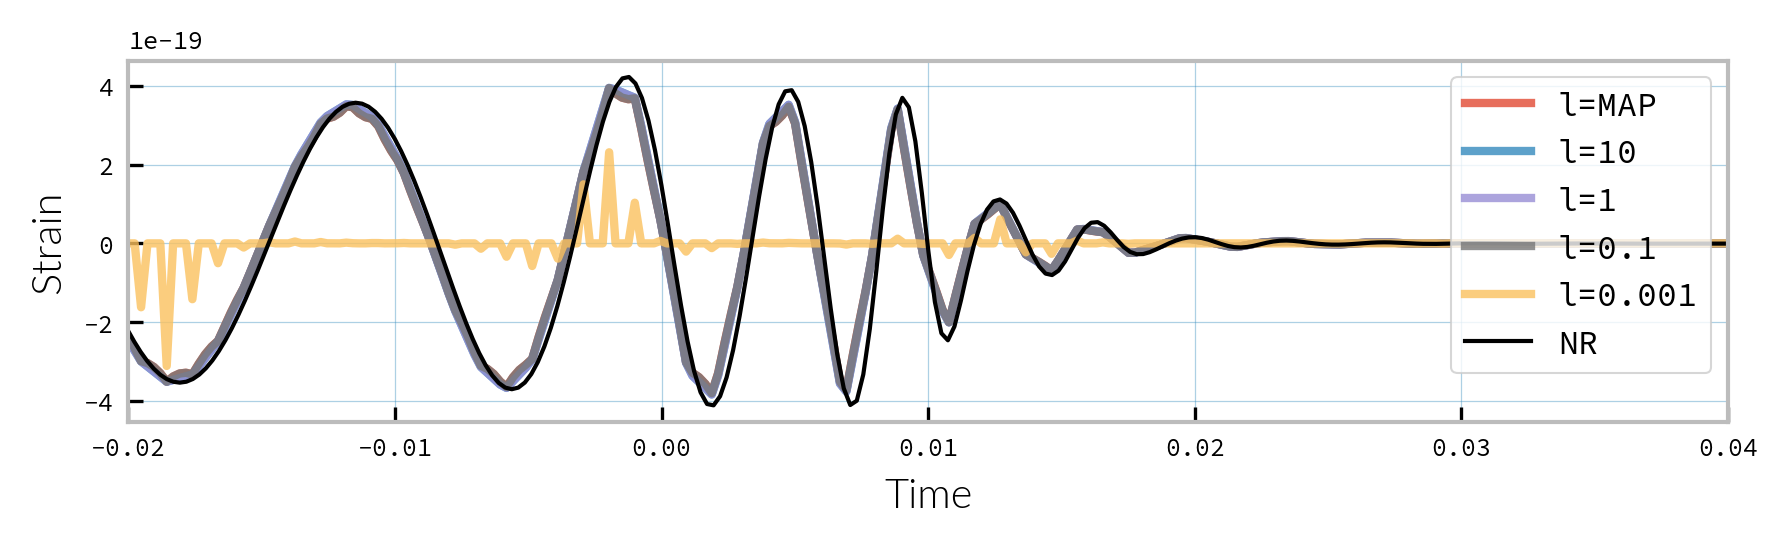

In [61]:
f, ax = plt.subplots(1,1, dpi=300);

ax.set_ylabel("Strain");
ax.set_xlabel("Time");

t_new = np.linspace(-0.02,0.1, 500)[::,None]

mu, var = gp.predict(t_new, point=mp, diag=True)
sd = np.sqrt(var)
ax.plot(t_new, mu/1e19, label="l=MAP".format(mp['time']), lw=2, alpha=0.8)

for l in [10, 1, 0.1, 0.001]:

    mp['time'] = np.array(l)
    mp['time_interval__'] = np.array(np.log(mp['time']))
    mu, var = gp.predict(t_new, point=mp, diag=True)
    sd = np.sqrt(var)
    ax.plot(t_new, mu/1e19, label="l={}".format(l), lw=2, alpha=0.8)

    

ax.set_xlim([-0.02, 0.04])
    
data = catalogue.waveforms[0].timeseries(total_mass=60, sample_rate = 4096)
ax.plot(data[0].times, data[0].data, label="NR", color ='k', lw=1);
ax.legend(prop=thesis.ssp_legend, loc="upper right")

thesis.thesisify(f, height=0.5);

